In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from models import *
import random as rd
import logging
import os
from tqdm import tqdm
%matplotlib inline
from random import randrange
from pycbc import distributions
from pycbc.waveform import get_td_waveform

dtype = torch.float32

In [4]:
def get_network(path=None, device='cpu'):
    """Return an instance of a network.
    
    Arguments
    ---------
    path : {None or str, None}
        Path to the network (weights) that should be loaded. If None
        a new network will be initialized.
    device : {str, 'cpu'}
        The device on which the network is located.
    
    Returns
    -------
    network
    """

    network = torch.nn.Sequential(        # Shapes
        #torch.nn.BatchNorm1d(2),#  2x2048
        #torch.nn.BatchNorm1d(1),#  2x2048
        #torch.nn.Conv1d(2, 4, 64),        #  4x1985
        torch.nn.Conv1d(1, 8, 64),        #  8x100
        torch.nn.ELU(),                    #  4x1985
        #torch.nn.Conv1d(4, 4, 32),        #  4x1954
        torch.nn.Conv1d(8, 4, 16),        #  4x1954
        torch.nn.MaxPool1d(4),            #  4x 489
        torch.nn.ELU(),                    #  4x 489
        torch.nn.Conv1d(4, 8, 32),        #  8x 458
        torch.nn.ELU(),                    #  8x 458
        torch.nn.Conv1d(8, 8, 16),        #  8x 443
        torch.nn.MaxPool1d(3),            #  8x 147
        torch.nn.ELU(),                    #  8x 147
        torch.nn.Conv1d(8, 16, 16),        # 16x 132
        torch.nn.ELU(),                    # 16x 132
        torch.nn.Conv1d(16, 16, 16),    # 16x 117
        torch.nn.MaxPool1d(4),            # 16x  29
        torch.nn.ELU(),                    # 16x  29
        torch.nn.Flatten(),                #     464
        torch.nn.Linear(464, 32),        #      32
        torch.nn.Dropout(p=0.5),        #      32
        torch.nn.ELU(),                    #      32
        torch.nn.Linear(32, 16),        #      16
        torch.nn.Dropout(p=0.5),        #      16
        torch.nn.ELU(),                    #      16
        torch.nn.Linear(16, 2),            #       2
        torch.nn.Softmax(dim=1)            #       2
        )
    
    if path is not None:
        network.load_state_dict(torch.load(path))
    network.to(dtype=dtype, device=device)
    return network

In [5]:
def train(Network, training_dataset, validation_dataset, output_training,
          weights_path, store_device='cpu', train_device='cpu',
          batch_size=32, learning_rate=5e-5, epochs=100, clip_norm=100,
          verbose=False):
    """Train a network on given data.
    
    Arguments
    ---------
    Network : network as returned by get_network
        The network to train.
    training_dataset : (np.array, np.array)
        The data to use for training. The first entry has to contain the
        input data, whereas the second entry has to contain the target
        labels.
    validation_dataset : (np.array, np.array)
        The data to use for validation. The first entry has to contain
        the input data, whereas the second entry has to contain the
        target labels.
    output_training : str
        Path to a directory in which the loss history and the best
        network weights will be stored.
    weights_path: str
        Path where the trained network weights will be stored.
    store_device : {str, `cpu`}
        The device on which the data sets should be stored.
    train_device : {str, `cpu`}
        The device on which the network should be trained.
    batch_size : {int, 32}
        The mini-batch size used for training the network.
    learning_rate : {float, 5e-5}
        The learning rate to use with the optimizer.
    epochs : {int, 100}
        The number of full passes over the training data.
    clip_norm : {float, 100}
        The value at which to clip the gradient to prevent exploding
        gradients.
    verbose : {bool, False}
        Print update messages.
    
    Returns
    -------
    network
    """
    ### Set up data loaders as a PyTorch convenience
    logging.debug("Setting up datasets and data loaders.")

    TrainDS = Dataset(*training_dataset, store_device=store_device, train_device=train_device)
    ValidDS = Dataset(*validation_dataset, store_device=store_device, train_device=train_device)
    TrainDL = torch.utils.data.DataLoader(TrainDS, batch_size=batch_size, shuffle=True)
    #ValidDL = torch.utils.data.DataLoader(ValidDS, batch_size=500, shuffle=True)
    ValidDL = torch.utils.data.DataLoader(ValidDS, batch_size=batch_size, shuffle=True)

    ### Initialize loss function, optimizer and output file
    logging.debug("Initializing loss function, optimizer and output file.")
    #loss = reg_BCELoss(dim=2)
    loss = reg_BCELoss(dim=1)

    opt = torch.optim.Adam(Network.parameters(), lr=learning_rate)
    with open(os.path.join(output_training, 'losses.txt'), 'w') as outfile:
        ### Training loop
        best_loss = 1.e10 # impossibly bad value
        iterable1 = range(1, epochs+1)
        iterable1 = tqdm(iterable1, desc="Optimizing network") if verbose else iterable1
        for epoch in iterable1:
            print(epoch) if verbose else None
            # Training epoch
            Network.train()
            #model.train()
            training_running_loss = 0.
            training_batches = 0
            iterable2 = TrainDL
            iterable2 = tqdm(iterable2, desc="Iterating over training dataset", leave=False) if verbose else iterable2
        

            for training_samples, training_labels in iterable2:
                # Optimizer step on a single batch of training data
                opt.zero_grad()
                training_output = Network(training_samples)
                training_loss = loss(training_output, training_labels)
                training_loss.backward()
            
                # Clip gradients to make convergence somewhat easier
                torch.nn.utils.clip_grad_norm_(Network.parameters(), max_norm=clip_norm)
                # Make the actual optimizer step and save the batch loss
                opt.step()
                training_running_loss += training_loss.clone().cpu().item()
                training_batches += 1
            # Evaluation on the validation dataset
            Network.eval()
            with torch.no_grad():
                validation_running_loss = 0.
                validation_batches = 0
                iterable2 = ValidDL
                iterable2 = tqdm(iterable2, desc="Computing validation loss", leave=False) if verbose else iterable2
                for validation_samples, validation_labels in iterable2:
                    # Evaluation of a single validation batch
                    validation_output = Network(validation_samples)
                    validation_loss = loss(validation_output, validation_labels)
                    validation_running_loss += validation_loss.clone().cpu().item()
                    validation_batches += 1
            # Print information on the training and validation loss in the current epoch and save current network state
            validation_loss = validation_running_loss/validation_batches
            output_string = '%04i    %f    %f' % (epoch, training_running_loss/training_batches, validation_loss)
            outfile.write(output_string + '\n')
            # Save 
            if validation_loss<best_loss:
                torch.save(Network.state_dict(), weights_path)
                best_loss = validation_loss

        logging.debug(("Training complete with best validation loss "
                        "%f, closing losses output file." % best_loss))
    
    Network.load_state_dict(torch.load(weights_path))
    return Network

In [6]:
def wave_model():
    mass1_distribution = distributions.uniform_log.UniformLog10(mass1=(5, 95))
    mass1_value=mass1_distribution.rvs(size=1)
    mass2_distribution = distributions.uniform_log.UniformLog10(mass2=(5, 95))
    mass2_value=mass2_distribution.rvs(size=1)

    hp, hc = get_td_waveform(approximant='SEOBNRv4',
                                     mass1=mass1_value['mass1'],
                                     mass2=mass2_value['mass2'],
                                     delta_t=1.0/4096,
                                     f_lower=40)
    return hp, hc

In [7]:
class reg_BCELoss(torch.nn.BCELoss):
    def __init__(self, *args, epsilon=1e-6, dim=None, **kwargs):
        torch.nn.BCELoss.__init__(self, *args, **kwargs)
        assert isinstance(dim, int)
        self.regularization_dim = dim
        self.regularization_A = epsilon
        self.regularization_B = 1. - epsilon*self.regularization_dim
    def forward(self, inputs, target, *args, **kwargs):
        assert inputs.shape[-1]==self.regularization_dim
        transformed_input = self.regularization_A + self.regularization_B*inputs
        # xisco: i changed target to target.unsqueeze(1)
        return torch.nn.BCELoss.forward(self, transformed_input, target.unsqueeze(1), *args, **kwargs)

In [8]:
### Basic dataset class for easy PyTorch loading
class Dataset(torch.utils.data.Dataset):
    def __init__(self, samples, labels,
                store_device='cpu', train_device='cpu'):
        torch.utils.data.Dataset.__init__(self)
        self.samples = torch.from_numpy(samples)
        self.labels = torch.from_numpy(labels)
        self.samples = self.samples.to(dtype=dtype,device=store_device)
        self.labels = self.labels.to(dtype=dtype,device=store_device)
        self.train_device = train_device
        assert len(self.samples)==len(self.labels)
        return
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        sample = self.samples[i].to(device=self.train_device)
        label = self.labels[i].to(device=self.train_device)
        return sample, label

In [9]:
# Device
DEVICE = torch.device('cuda: 3' if torch.cuda.is_available() else 'cpu')
# instantiate model
model =  ConvNet5().to(DEVICE)
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-5)
#learning rate
lr_sched = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
# summary
#summary(model, input_size=(1,4096))

In [10]:
# choose the training and test datasets
train_set = pd.read_csv("./output/train.csv", dtype=np.float32)

# Seperate the features and labels
total_train_label = train_set.label.values
total_train_data = train_set.loc[:, train_set.columns != 'label'].values
total_train_data  = total_train_data.reshape(-1, 1, 4096)

# Split into training and test set
data_train, data_valid, label_train, label_valid = train_test_split(total_train_data, total_train_label, test_size=0.1, random_state=2)

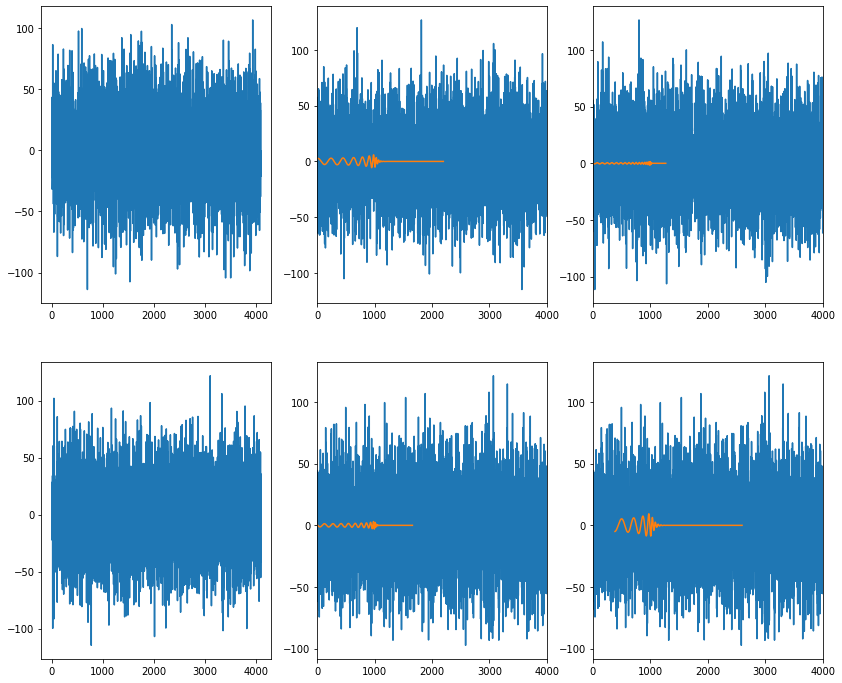

In [11]:
my_list = []
plt.figure(figsize=(14,12))
for i in range(1,7):
    ran_int = rd.randint(0, len(data_train)-1)
    plt.subplot(2,3,i)
    if label_train[ran_int] == 1:
        wave =  wave_model()[0]
        plt.plot(data_train[ran_int][0])
        plt.plot(1000+wave.sample_times.data*10000,10**19*wave.data)
        plt.xlim(0,4000)
    else:
        plt.plot(data_train[ran_int][0])

In [13]:
data_train_label = [data_train,label_train]
data_valid_label = [data_valid,label_valid]

In [14]:
train(model, data_train_label,data_valid_label,'/work/francisco.jimenez/sio/git/MLtests/','/work/francisco.jimenez/sio/git/MLtests/wigths.txt', store_device='cpu', train_device='cpu',
         batch_size=20, learning_rate=5e-5, epochs=100, clip_norm=100,verbose=False)

ConvNet5(
  (conv1): Conv1d(1, 16, kernel_size=(16,), stride=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(8,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3904, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

<Figure size 432x288 with 0 Axes>

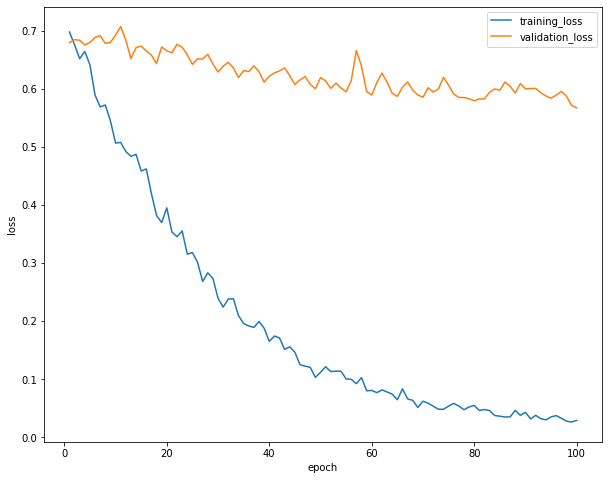

In [15]:
read_file=np.loadtxt('/work/francisco.jimenez/sio/git/MLtests/losses.txt')

plt.figure(1);
plt.figure(figsize=(10,8));
plt.plot(read_file[:,0],read_file[:,1],label='training_loss')
plt.plot(read_file[:,0],read_file[:,2],label='validation_loss')
plt.legend()

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()